#### Importing Packages

In [2]:
import pylab
import h5py
import math
import array
from numpy import *
import numpy as np
from pycbc.types import TimeSeries, FrequencySeries
from pycbc.waveform import get_td_waveform, get_fd_waveform

from gw_eccentricity import load_waveform, load_data, get_available_methods, measure_eccentricity
from gw_eccentricity.load_data import get_available_waveform_origins, get_load_waveform_defaults, get_load_waveform_docs

from gw_eccentricity.plot_settings import use_fancy_plotsettings, labelsDict
from pycbc.waveform.waveform_modes import get_td_waveform_modes
from pycbc import types, fft, waveform
import lal
from scipy import interpolate
from scipy.interpolate import interp1d
from lal import MSUN_SI, MTSUN_SI, G_SI, PC_SI, C_SI, PI
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
from tqdm import tqdm
import matplotlib as mpl
from matplotlib import gridspec
from matplotlib import ticker

import matplotlib.pyplot as plt
from IPython.display import HTML,display
import pandas as pd
mode2polfac=4*(5/(64*np.pi))**(1/2)

#### Binary parameters 

In [3]:
origin = "LAL"

q = 1
M = 30
M1=q*M/(1+q)
M2=M/(1+q)

D = 1
e0 = 0.12   
l0 = 1.423
xlow = 0.045 
D_SI=D*(10**(6))*PC_SI
M_SI=M*MSUN_SI

mode2polfac=4*(5/(64*np.pi))**(1/2)

fMIN=(0.045**(3/2)/(M*MTSUN_SI*math.pi)) 
fref=(0.075**(3/2)/(M*MTSUN_SI*math.pi)) 

print(fMIN, fref) 

20.563550931756406 44.245716831989206


#### Creating a dataDict for gw_eccentricity package

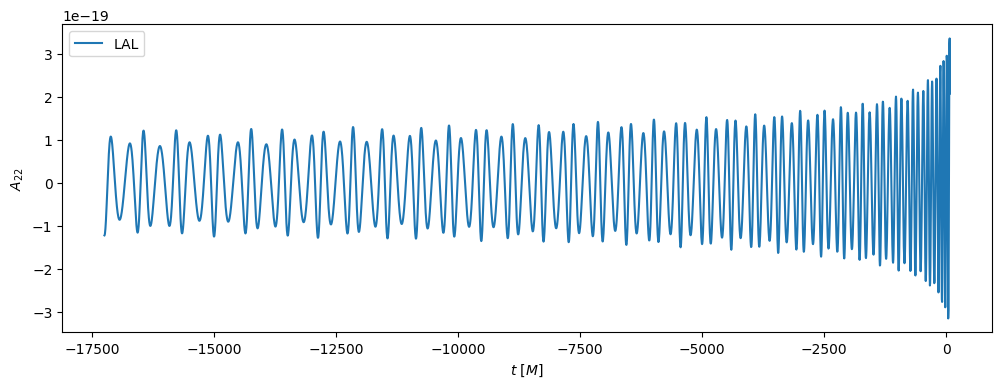

In [4]:
kwargs = {
    "approximant": "EccentricTD",
    "q": q,
    "ecc": e0,
    "chi1": [0.0,0.0,0.0],
    "chi2": [0.0,0.0,0.0],
    "mean_ano": l0,
    "Momega0": xlow**(3/2),
    "physicalUnits":True,
    "deltaTOverM": 5,
    "M": M,
    "D": D,
    "include_zero_ecc":True,
}

dataDict = load_waveform(origin, **kwargs)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(dataDict["t"]/(M*MTSUN_SI), np.real(dataDict["hlm"][(2, 2)]), label = origin)
ax.set_xlabel(labelsDict["t_dimless"])
ax.set_ylabel(labelsDict["amp22"])
ax.legend(loc="upper left")

#### Calculating $e_{gw}$ from the package at a reference frequency

In [5]:
method = 'AmplitudeFits'
return_dict = measure_eccentricity(fref_in=fref, method = method, dataDict = dataDict)

eccentricity = return_dict["eccentricity"]
Mean_ano = return_dict["mean_anomaly"]
fref = return_dict["fref_out"]
gwecc_object= return_dict["gwecc_object"]

print(fref,(eccentricity),Mean_ano, M)

44.245716831989206 0.09140140543037645 2.03941046852529 30


#### Extracting out the polarizations and phase from dataDict

In [5]:
hp = np.real(dataDict["hlm"][(2,2)])
hc = np.imag(dataDict["hlm"][(2,2)])
phaseEcc = np.unwrap(np.angle(hp-1j*hc)*2)/2

#### Plotting frequency as a function of time

Text(0, 0.5, '$(2,2)$ mode Frequency')

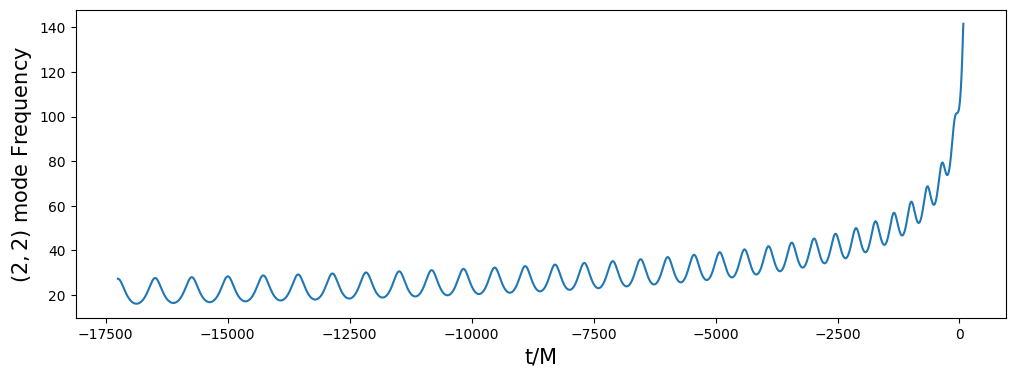

In [7]:
plt.figure(figsize=(12,4))
delta_t =  np.abs(np.mean((np.diff(dataDict["t"]))))
omega22 = (1/delta_t)*(np.gradient(phaseEcc))
plt.plot(dataDict["t"]/(M*MTSUN_SI),omega22/(2*PI))
plt.xlabel('t/M',fontsize=15)
plt.ylabel(r'$(2,2)$ mode Frequency',fontsize=15)

#### Generating eccentricity dataset from reference frequency dataset

In [8]:
plt.figure(figsize=(12,4))
method = 'ResidualAmplitude'
return_dict_1 = measure_eccentricity(fref_in=omega22/(2*PI), method = method, dataDict = dataDict)

eccentricity1 = return_dict_1["eccentricity"]
fref = return_dict_1["fref_out"]

print(len(fref), len(eccentricity1))

2696 2696


<Figure size 1200x400 with 0 Axes>

#### Generating eccentricity dataset from time dataset

In [9]:
method = 'ResidualAmplitude'
return_dict = measure_eccentricity(tref_in=dataDict["t"], method = method, dataDict = dataDict)
eccentricity = return_dict["eccentricity"]
tref = return_dict["tref_out"]
gwecc_object= return_dict["gwecc_object"]
avg_freq = (gwecc_object.get_omega22_average()[1])/(2*PI)

#### Figuring out indices where values of tref and dataDict["t"] coincide

In [11]:
#print((np.intersect1d(dataDict["t"],tref)))
ind_min = np.where(dataDict["t"]==min(tref))[0][0]
ind_max = np.where(dataDict["t"]==max(tref))[0][0]
print(ind_min,ind_max,len(omega22))

152 3348 3467


#### Plotting eccentricity-actual frequency and eccentricity-avg frequency curve

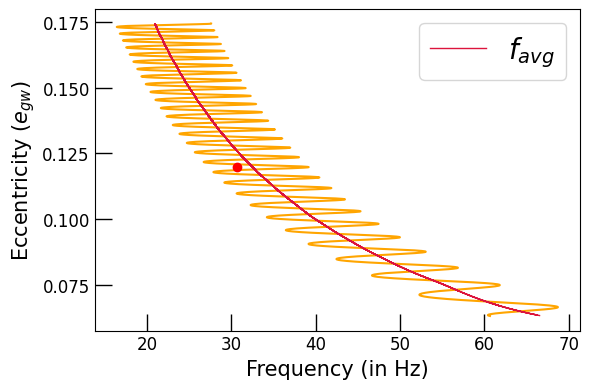

In [12]:
plt.figure(figsize=(6,4))
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
mpl.rcParams['xtick.major.size'] = 12
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 8
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 12
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 8
mpl.rcParams['ytick.minor.width'] = 1
plt.locator_params(axis='y',nbins=6)
plt.tick_params(axis='y',direction='in')
plt.tick_params(axis='x',direction='in')
Freq = (omega22/(2*PI))
plt.plot(Freq[ind_min:ind_max+1],eccentricity,color='orange')
plt.plot(fref,eccentricity1,color='crimson',linewidth=1,label=r'$f_{avg}$')
plt.plot(30.653184814297973,0.1199970320639913,'ro')
plt.xlabel('Frequency (in Hz)',fontsize=15)
plt.ylabel(r'Eccentricity $(e_{gw}$)', fontsize=15)
plt.legend(fontsize=20)
plt.tight_layout()

#### Saving (eccentricity, frequency) pairs as a data file to be used for PN-NR match calculations 

In [13]:
dict_csv = {'Frequency': Freq[ind_min:ind_max+1], 'Eccentricity':eccentricity}
df = pd.DataFrame(dict_csv)
print(df)
df.to_csv('Ecc vs Freq_1355.csv')

      Frequency  Eccentricity
0     27.621061      0.174454
1     27.621843      0.174437
2     27.602212      0.174420
3     27.562326      0.174403
4     27.502493      0.174386
...         ...           ...
3192  60.431177      0.063472
3193  60.406398      0.063366
3194  60.434906      0.063260
3195  60.517606      0.063155
3196  60.655203      0.063052

[3197 rows x 2 columns]
